In [ ]:
!pip install adabelief-pytorch
!pip install timm

     |████████████████████████████████| 296kB 13.1MB/s 


In [ ]:
import torchvision
from torchvision import transforms

import torch.utils.data.dataloader
import matplotlib.pyplot as plt


import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,ConcatDataset
import adabelief_pytorch
import numpy  as np

from sklearn.metrics import roc_auc_score, auc
from scipy import stats

In [ ]:
import torchvision.models.vgg as vgg

In [ ]:
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from timm.models.efficientnet_blocks import round_channels, resolve_bn_args, resolve_act_layer, BN_EPS_TF_DEFAULT
from timm.models.efficientnet_builder import EfficientNetBuilder, decode_arch_def, efficientnet_init_weights
from timm.models.features import FeatureInfo, FeatureHooks
from timm.models.helpers import build_model_with_cfg, default_cfg_for_features
from timm.models.layers import create_conv2d, create_classifier
from timm.models.registry import register_model


In [ ]:
import timm
import timm.models.efficientnet

In [ ]:
import timm.models.vision_transformer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(444)
if device =='cuda':
    torch.cuda.manual_seed_all(444)

In [ ]:
model=timm.models.efficientnet_b0(pretrained=False)
#model2=timm.models.vision_transformer.vit_large_patch16_224(pretrained=False)

In [ ]:
model1.parameters

<bound method Module.parameters of EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identit

In [ ]:
model3=torchvision.models.vgg16(pretrained=False)

In [ ]:
sum(p.numel() for p in model3.parameters())

138357544

In [ ]:
sum(p.numel() for p in model1.parameters())

5288548

In [ ]:
sum(p.numel() for p in model2.parameters())

304326632

In [ ]:
model=timm.models.mnasnet_075(pretrained=False)
model.reset_classifier(1)
model.drop_rate=0.5
model=model.to(device)

In [ ]:
model=timm.models.efficientnet.efficientnet_b0(pretrained=False).to(device)
model.reset_classifier(1)
model.drop_rate=0.5

model=model.to(device)

In [ ]:

a=torch.Tensor(1,3,224,224).to(device)
out = model(a)
print(out)

tensor([[0.0563]], device='cuda:0', grad_fn=<AddmmBackward>)


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
PATH='/content/gdrive/MyDrive/Colab Notebooks/jaundice/'

In [ ]:
class CustomDataset(Dataset): 
  def __init__(self,x,y):
    #self.transform=transform
    self.x_0_data = x[:,:,0:112,:]
    
    self.x_1_data=x[:,:,112:,:]
    self.y_data = y

  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.y_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    
    #x_0=pilimg.fromarray(self.x_0_data[idx].astype(np.uint8))
    #x_0=self.transform(x_0)
    x_0 = torch.FloatTensor(self.x_0_data[idx])
    #x_0=F.interpolate(x_0,size=(224,224),mode='bilinear',align_corners=False)
    x_1= torch.FloatTensor(self.x_1_data[idx])
    #x_1=F.interpolate(x_1,size=(224,224),mode='bilinear',align_corners=False)
    y = torch.FloatTensor(self.y_data[idx])
    return x_0,x_1, y

In [ ]:
trainset=torch.load(PATH+'normsplitjaundicetrainset.csv')
testset=torch.load(PATH+'normsplitjaundicetestset.csv')


trainbatchsize=8
testbatchsize=1
trainloader=torch.utils.data.DataLoader(trainset,batch_size=trainbatchsize,shuffle=True,num_workers=4,drop_last=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=testbatchsize,shuffle=False,num_workers=4)

In [ ]:
zt=torch.zeros((1,3,224,224)).to(device)
for i, data in enumerate(testloader, 0):
    # get the inputs
    inputs_0,inputs_1, labels = data
    zt[:,:,0:112,:] = inputs_0.to(device)
    zt[:,:,112:,:] = inputs_1.to(device)
    zt=zt.cpu()
    plt.imshow(zt[0].permute(1, 2, 0))

***Patch or not***

In [ ]:
experiment='withoutpatch'

***binary classification training***

In [ ]:
criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
optimizer=adabelief_pytorch.AdaBelief(model.parameters(),lr=0.001)
#lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

sig=nn.Sigmoid()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


In [ ]:
trainedepochs=0
print(len(trainloader))

epochs = 20
z=torch.zeros((trainbatchsize,3,224,224)).to(device)
outarr=np.zeros(len(testloader))
labarr=np.zeros(len(testloader))

for epoch in range(epochs):
  model.train()
  
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs_0,inputs_1, labels = data
    z[:,:,0:112,:] = inputs_0.to(device)
    z[:,:,112:,:] = inputs_1.to(device)

    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(z)

    labels=labels.to(torch.float)/10
    
    for j in range(len(labels)):
      if (labels[j][0]<1.3):
        labels[j][0]=0
      else: 
        labels[j][0]=1
 
       # (numarray.max()/numarray[labels[0][0].to(torch.int).tolist()-1])
    #loss = (1/numnum[labels[0][0].to(torch.int).tolist()-1])*criterion(outputs, labels.to(torch.float)/10)
    loss = criterion(outputs, labels)
    
    #print( (numnum.max()/numnum[labels[0][0].to(torch.int).tolist()-1]))
    loss.backward()
    optimizer.step()

        # print statistics
    running_loss += loss.item()
    if i % 20 == 19:    
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 20))
      running_loss = 0.0
    #lr_sche.step()
  
  
  if (epoch%5==4):
    model.eval()
    

    with torch.no_grad():
      for i, data in enumerate(testloader, 0):
        inputs_0,inputs_1, labels = data
        z[:,:,0:112,:] = inputs_0.to(device)
        z[:,:,112:,:] = inputs_1.to(device)
        labels = labels.to(device)
        # zeo the parameter gradients
        # forward + backward + optimize
        outputs = model(z)
        labels=labels.to(torch.float)/10

        

        for j in range(len(labels)):
          if (labels[j][0]<1.3):
            labels[j][0]=0
          else: 
            labels[j][0]=1
 
        
        outarr[i]=sig(outputs[0][0]).cpu().numpy()
        labarr[i]=(labels[0][0].cpu().numpy())
      #print(labarr,outarr)
      print(roc_auc_score(labarr,outarr))


        


  if (epoch==50 or epoch==100 or epoch==150 or epoch==200 or epoch==250 or epoch==300 or epoch==350 or epoch==400 or epoch==450 or epoch==500 or epoch==550):
    torch.save(model.state_dict,PATH+'efficientnetb0test/'+experiment+'binmodel{}.pt'.format(trainedepochs+epoch))  
    if (epoch==100 or epoch==200 or epoch==300 or  epoch==400 or epoch==500 ):
      torch.save(optimizer.state_dict, PATH+'efficientnetb0test/'+experiment+'binoptimizer{}.pt'.format(trainedepochs+epoch))

        
        
      
      # loop over the dataset multiple times

    #Check Accuracy
    #acc = acc_check(resnet50, testloader, epoch, save=1)
    
    
torch.save(model.state_dict,PATH+'efficientnetb0test/'+experiment+'binmodel{}.pt'.format(trainedepochs+epochs))
torch.save(optimizer.state_dict, PATH+'efficientnetb0test/'+experiment+'binoptimizer{}.pt'.format(trainedepochs+epochs))
print('Finished Training')

***regression training***

In [ ]:
len(trainset)

1034

In [ ]:
numset=torch.zeros((224,1))

In [ ]:

for j in range(len(numset)):
  cnt=0
  for i in range(len(trainset)):
    _,_,num=trainset[i]
    
    if num==j+1:
      cnt=cnt+1

  numset[j]=cnt   

In [ ]:
torch.save(numset, PATH+'nunmset.csv')

In [ ]:
numset=torch.load(PATH+'nunmset.csv')

In [ ]:
int(numset[1])/10

5.1

In [ ]:
#criterion=custom_loss()
optimizer=adabelief_pytorch.AdaBelief(model.parameters(),lr=0.001)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


In [ ]:

def mse_loss(
    input: Tensor,
    target: Tensor,
    size_average: Optional[bool] = None,
    reduce: Optional[bool] = None,
    reduction: str = "mean",
) -> Tensor:
    r"""mse_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor

    Measures the element-wise mean squared error.

    See :class:`~torch.nn.MSELoss` for details.
    """
    if has_torch_function_variadic(input, target):
        return handle_torch_function(
            mse_loss, (input, target), input, target, size_average=size_average, reduce=reduce, reduction=reduction
        )
    if not (target.size() == input.size()):
        warnings.warn(
            "Using a target size ({}) that is different to the input size ({}). "
            "This will likely lead to incorrect results due to broadcasting. "
            "Please ensure they have the same size.".format(target.size(), input.size()),
            stacklevel=2,
        )
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)

    expanded_input, expanded_target = torch.broadcast_tensors(input, target)
    return torch._C._nn.mse_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))



In [ ]:
class customMSELoss(_Loss):
  def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(customMSELoss, self).__init__(size_average, reduce, reduction)

  def forward(self, input: Tensor, target: Tensor) -> Tensor:
        
        return mse_loss(input, target, reduction=self.reduction)


In [ ]:
_,_,lab=trainset[0]

In [ ]:
int(lab[0])

1

In [ ]:
def custom_loss(output, target, numset):
  batchsize=len(output)
  
  inloss=torch.empty(batchsize)

  for i in range(batchsize):
    inloss[i]=torch.square(output[i]-target[i]/10)
    inloss[i]=inloss[i]*(torch.pow((numset[int(target[i][0])-1]),-1))
  
  

  loss=torch.mean(inloss)
  
  return loss


In [ ]:
class weightMSELoss(nn.Module):
  def forward(self,input,target,numset):
    return custom_loss(input,target,numset)

In [ ]:
criterion=weightMSELoss()

In [ ]:

print(len(trainloader))

103


In [ ]:
trainedepochs=0
print(len(trainloader))

epochs = 400
z=torch.zeros((trainbatchsize,3,224,224)).to(device)
zt=torch.zeros((testbatchsize,3,224,224)).to(device)
outarr=np.zeros(len(testloader))
labarr=np.zeros(len(testloader))

for epoch in range(epochs):
  model.train()
  
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs_0,inputs_1, labels = data
    
    z[:,:,0:112,:] = inputs_0.to(device)
    z[:,:,112:,:] = inputs_1.to(device)

    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(z)

    labels=labels.to(torch.float)
    '''
    for j in range(len(labels)):
      if (labels[j][0]<1.3):
        labels[j][0]=0
      else: 
        labels[j][0]=1
    '''
       # (numarray.max()/numarray[labels[0][0].to(torch.int).tolist()-1])
    #loss = (1/numnum[labels[0][0].to(torch.int).tolist()-1])*criterion(outputs, labels.to(torch.float)/10)
    loss = criterion(outputs, labels,numset)
    #loss=custom_loss(outputs,labels,numset)
    #print( (numnum.max()/numnum[labels[0][0].to(torch.int).tolist()-1]))
    loss.backward()
    optimizer.step()

        # print statistics
    running_loss += loss.item()
    if i % 20 == 19:    
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 20))
      running_loss = 0.0
    #lr_sche.step()
  
  
  if (epoch%4==3):
    model.eval()
    

    with torch.no_grad():
      for i, data in enumerate(testloader, 0):
        inputs_0,inputs_1, labels = data
        zt[:,:,0:112,:] = inputs_0.to(device)
        zt[:,:,112:,:] = inputs_1.to(device)
        labels = labels.to(device)
        # zeo the parameter gradients
        # forward + backward + optimize
        outputs = model(zt)
        labels=labels.to(torch.float)/10

        
        '''
        for j in range(len(labels)):
          if (labels[j][0]<1.3):
            labels[j][0]=0
          else: 
            labels[j][0]=1
        '''
        
        outarr[i]=outputs[0][0].cpu().numpy()
        labarr[i]=(labels[0][0].cpu().numpy())
        
      
      #print(labarr,outarr)
      np.savetxt(PATH+'batsize{}_{}_pred{}_norm_nopatch_b0.txt'.format(trainbatchsize,np.corrcoef(labarr,outarr)[0][1],epoch+trainedepochs),outarr)
      np.savetxt(PATH+'lab.txt',labarr)
      print(np.corrcoef(labarr,outarr)[0][1])
      print(stats.spearmanr(labarr,outarr))



        

  '''
  if (epoch==50 or epoch==100 or epoch==150 or epoch==200 or epoch==250 or epoch==300 or epoch==350 or epoch==400 or epoch==450 or epoch==500 or epoch==550):
    torch.save(model.state_dict,PATH+'efficientnetb0test/'+experiment+'regmodel{}.pt'.format(trainedepochs+epoch))  
    if (epoch==100 or epoch==200 or epoch==300 or  epoch==400 or epoch==500 ):
      torch.save(optimizer.state_dict, PATH+'efficientnetb0test/'+experiment+'regoptimizer{}.pt'.format(trainedepochs+epoch))
  '''
        
        
      
      # loop over the dataset multiple times

    #Check Accuracy
    #acc = acc_check(resnet50, testloader, epoch, save=1)
    
'''  
torch.save(model.state_dict,PATH+'efficientnetb0test/'+experiment+'regmodel{}.pt'.format(trainedepochs+epochs))
torch.save(optimizer.state_dict, PATH+'efficientnetb0test/'+experiment+'regoptimizer{}.pt'.format(trainedepochs+epochs))
print('Finished Training')
'''

129
[1,    20] loss: 3.164
[1,    40] loss: 2.147
[1,    60] loss: 1.889
[1,    80] loss: 0.831
[1,   100] loss: 4.023
[1,   120] loss: 1.706
[2,    20] loss: 0.771
[2,    40] loss: 0.885
[2,    60] loss: 1.302
[2,    80] loss: 0.992
[2,   100] loss: 1.005
[2,   120] loss: 1.131
[3,    20] loss: 0.637
[3,    40] loss: 1.045
[3,    60] loss: 0.510
[3,    80] loss: 0.730
[3,   100] loss: 1.371
[3,   120] loss: 1.206
[4,    20] loss: 0.521
[4,    40] loss: 1.554
[4,    60] loss: 0.620
[4,    80] loss: 0.650
[4,   100] loss: 1.752
[4,   120] loss: 0.571
0.8647115089476058
SpearmanrResult(correlation=0.49254755160373387, pvalue=1.7708112038293087e-27)
[5,    20] loss: 0.428
[5,    40] loss: 0.461
[5,    60] loss: 1.025
[5,    80] loss: 1.789
[5,   100] loss: 0.979
[5,   120] loss: 0.650
[6,    20] loss: 0.427
[6,    40] loss: 0.754
[6,    60] loss: 0.578
[6,    80] loss: 0.766
[6,   100] loss: 1.209
[6,   120] loss: 0.568
[7,    20] loss: 1.325
[7,    40] loss: 0.626
[7,    60] loss: 0.419


"  \ntorch.save(model.state_dict,PATH+'efficientnetb0test/'+experiment+'regmodel{}.pt'.format(trainedepochs+epochs))\ntorch.save(optimizer.state_dict, PATH+'efficientnetb0test/'+experiment+'regoptimizer{}.pt'.format(trainedepochs+epochs))\nprint('Finished Training')\n"

In [ ]:
x=np.loadtxt(PATH+'batsize8_0.9036212057098972_pred399_norm_nopatch_b0.txt')
y=np.loadtxt(PATH+'lab.txt')

In [ ]:
stats.spearmanr(x1,y)

SpearmanrResult(correlation=0.7009007954098205, pvalue=2.3486217772876217e-64)

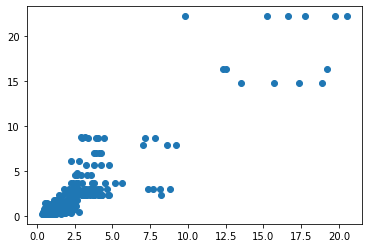

In [ ]:
plt.plot(x,y,'o')

In [ ]:
x1=np.loadtxt(PATH+'patchresult3/batsize10_0.9444401022864063_pred69_norm_patch_b0.txt')

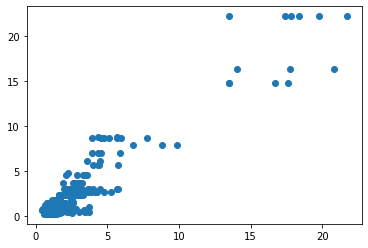

In [ ]:
plt.plot(x1,y,'o')

In [ ]:
stats.spearmanr(x,y)

SpearmanrResult(correlation=0.7387324181484703, pvalue=7.912146057155815e-75)

In [ ]:
stats.kendalltau(x,y)

KendalltauResult(correlation=0.5688278288887137, pvalue=1.3237586820729952e-65)

In [ ]:
import os
nopatchpath=PATH+'nopatchresult3'
patchpath=PATH+'patchresult3'

In [ ]:
file_list_nopat=os.listdir(nopatchpath)
file_list=os.listdir(patchpath)

In [ ]:
for i in range(len(file_list_nopat)):
  file_list_nopat[i]=file_list_nopat[i].split('_')
  file_list[i]=file_list[i].split('_')

In [ ]:
file_list_nopat

[['batsize10', '0.8116379881648721', 'pred4', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9351931137419167', 'pred9', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9072202692399882', 'pred14', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9260997282746999', 'pred19', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9151920155390321', 'pred24', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9123351570861127', 'pred29', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.8962720994802', 'pred34', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9193637286784673', 'pred39', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9195008863225032', 'pred44', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9271741744732681', 'pred49', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9265419014281016', 'pred54', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9155099785016605', 'pred59', 'norm', 'nopatch', 'b0.txt'],
 ['batsize10', '0.9384125742797408', 'pred64', 'norm', 'nopatch', 'b0.txt'],
 ['b

In [ ]:
print(file_list[0][1])

print(float(file_list[0][1]))

0.8401987384308033
0.8401987384308033


In [ ]:
nopat=np.zeros((len(file_list_nopat),1))
for i in range(len(file_list_nopat)):
  nopat[i]=float(file_list_nopat[i][1])

In [ ]:
pat=np.zeros((len(file_list),1))
for i in range(len(file_list)):
  pat[i]=float(file_list[i][1])

In [ ]:
y=np.zeros((len(file_list),1))
for i in range(len(file_list)):
  y[i]=5*(i+1)-1

In [ ]:
plt.plot(y,pat,'r',y,nopat,'g',)

NameError: ignored

In [ ]:
np.savetxt(PATH+'patres3.txt',pat)
np.savetxt(PATH+'nopatres3.txt',nopat)

In [ ]:
pat

array([[0.84019874],
       [0.87392702],
       [0.88095247],
       [0.9333725 ],
       [0.93176452],
       [0.9413818 ],
       [0.92306218],
       [0.93272258],
       [0.75575848],
       [0.93939771],
       [0.94577702],
       [0.935289  ],
       [0.9421702 ],
       [0.9377954 ],
       [0.93792023],
       [0.9419076 ],
       [0.92724499],
       [0.94598135],
       [0.94525692],
       [0.93537443],
       [0.939474  ],
       [0.93807919],
       [0.9364232 ],
       [0.93438439],
       [0.94124439],
       [0.94612855],
       [0.93127403],
       [0.94374485],
       [0.93888467],
       [0.78489923],
       [0.91577642],
       [0.94331304],
       [0.93851253],
       [0.93145875],
       [0.93644648],
       [0.93624826],
       [0.94693085],
       [0.93975983],
       [0.92100232],
       [0.92200964]])

In [ ]:
nopat

array([[0.84345062],
       [0.89946504],
       [0.90448784],
       [0.91386791],
       [0.91759643],
       [0.88863501],
       [0.88004312],
       [0.90438475],
       [0.87271197],
       [0.89972173],
       [0.90784555],
       [0.89183228],
       [0.88747658],
       [0.89497961],
       [0.93049925],
       [0.91803476],
       [0.9263071 ],
       [0.93108849],
       [0.91496374],
       [0.91907563],
       [0.93626964],
       [0.88462921],
       [0.91180522],
       [0.88261361],
       [0.92487993],
       [0.90000799],
       [0.92721823],
       [0.92611798],
       [0.90741161],
       [0.93078029],
       [0.90183916],
       [0.91717178],
       [0.87961872],
       [0.9216265 ],
       [0.91031418],
       [0.9161509 ],
       [0.91696394],
       [0.90908246],
       [0.92423613],
       [0.91849097]])